# Introduction

Here, I explore how different unsupervised ML algorithms cluster datasets with different structures. 

To do so, I use three different datasets consisting of points in a two dimensional space. Each point has an associated class which will serve to evaluate the performance of each clustering algorithm. 

Each dataset contains 1000 data points, each of them belonging to one of either 2 or 4 clases.

Each clustering algorithm has its own nuances which make it better in certain cases and worse in others. Along with the execution of the algorithms I will explain these nuances and how they affect the performance of the algorithm.

There is a "environment.yaml" file with the required packages and versions in this repository.

This notebook derives from exercises performed in the Data Science MSc by UOC.

In [2]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd

# Clustering-related
import sklearn
from sklearn import cluster        
from sklearn import datasets       
from sklearn import decomposition

# Visualization-related
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline

## Generation of datasets

In [3]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

list_vars = [X_blobs, y_blobs, X_moons, y_moons, X_circles, y_circles]
list_var_names = ["X_blobs", "y_blobs", "X_moons", "y_moons", "X_circles", "y_circles"]

for el in range(len(list_vars)):
    print("Dimensions of "+ list_var_names[el]+": "+ str(list_vars[el].shape))

for el in [1, 3, 5]:
    print("Number of unique elements in "+list_var_names[el][2:]+": "+str(len(np.unique(list_vars[el]))))

Dimensions of X_blobs: (1000, 2)
Dimensions of y_blobs: (1000,)
Dimensions of X_moons: (1000, 2)
Dimensions of y_moons: (1000,)
Dimensions of X_circles: (1000, 2)
Dimensions of y_circles: (1000,)
Number of unique elements in blobs: 4
Number of unique elements in moons: 2
Number of unique elements in circles: 2


We have 3 datasets ("Blobs", "Moons" and "Circles") each of them containing 1000 points. In the Blobs dataset we have 4 clases, whereas in the Moons and in the Circles dataset we have 2 clases.

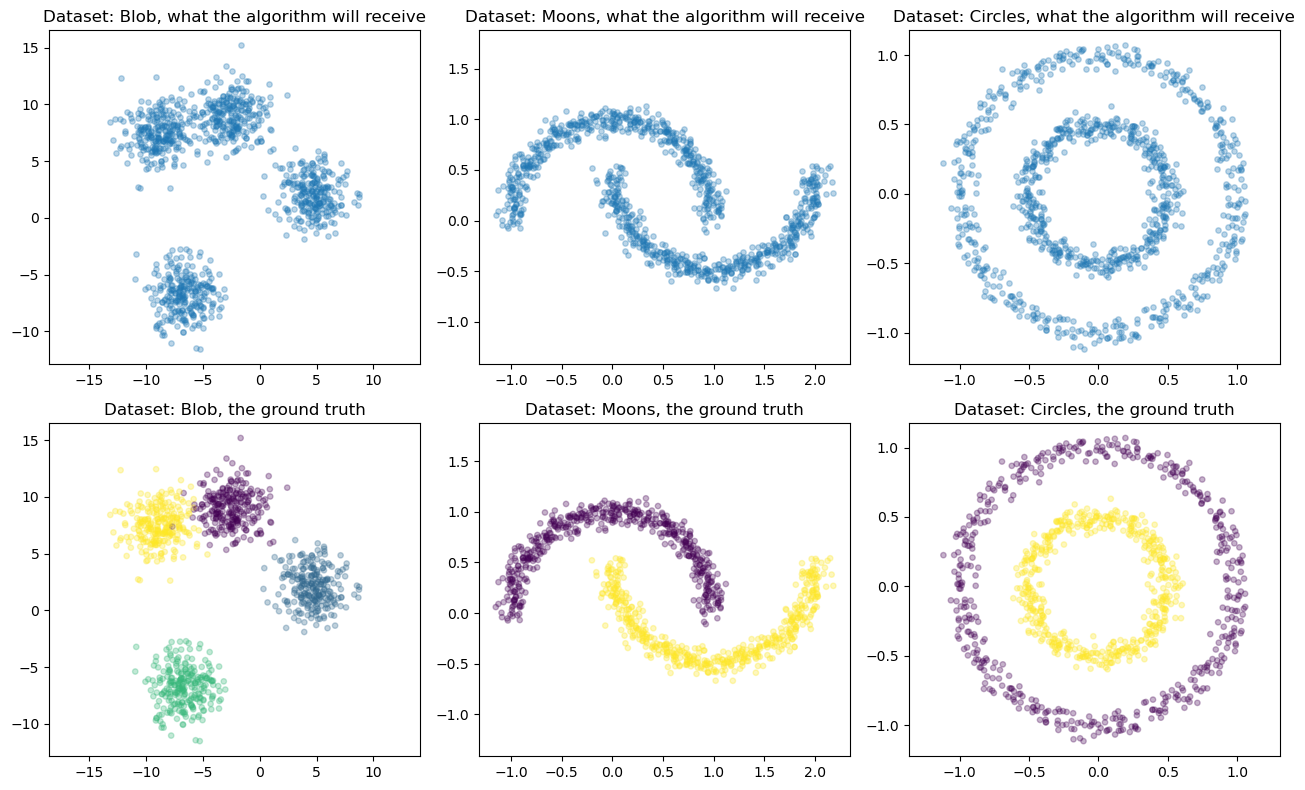

In [4]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('what the algorithm will receive' if i < 3 else 'the ground truth'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3)
    ax.axis('equal')
plt.tight_layout()

## 1.1 K-Means

*K-means* works by separating data points into a user-defined number (*k*) of clusters. Data points are assigned to specific cluster by computing the distance (there are different distance metrics) to cluster centroids, and iteratively re-locate the centroids until convergence is reached. The main difficulty when applying this algorithm consists in determining the correct number of clusters. It is important to remember that this an unsupervised learning algorithm, so the previous knowledge about the dataset might not be enough to make the choice of a number of clusters trivial. 

To help with determining the appropriate number of clusters, one common approach is to perform the K-means process a number of times, each of them with a different amount of clusters. For each number of clusters, the sum of the squared errors (SSE) is calculated by measuring the distance from each point to its centroid. By plotting the number of clusters vs its associated SSE the so-called *elbow plot* is generated. The number of clusters at which the reduction in SSE starts to be slower, or *elbow*, is the value of *K* to begin with. Here the formula for the SSE:

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

## 1.1.1. K-Means with the Blobs dataset

For each dataset, I will generate the elbow plot for the K-means and then run the algorithm with the elbow value for the *K* parameter.

Here the elbow plot for the Blobs dataset:

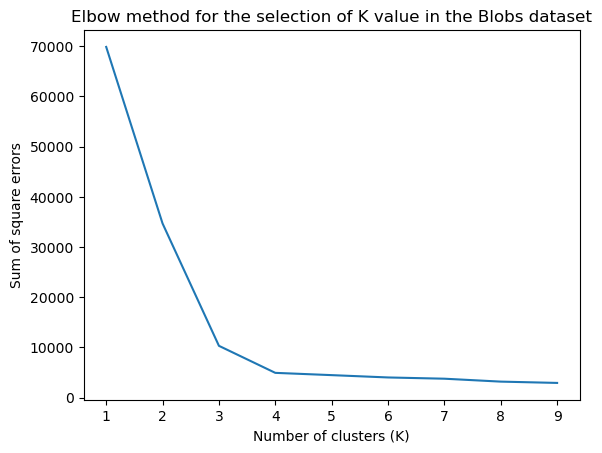

In [6]:
# Load the Bobs dataset as X and y variables
X, y = X_blobs, y_blobs

# Empty list to save SSEs
inertias = []

# Iterate through K values 1 to 10 and calculate SSE for each K value
for el in range(1,10):
    kmeans = cluster.KMeans(n_clusters=el,n_init='auto', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
# Generate elbow plot
plt.plot(range(1,10), inertias)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of square errors")
plt.title("Elbow method for the selection of K value in the Blobs dataset")
plt.show()

We know that there are, in fact, 4 distinct groups in the dataset, so it makes sense for the value to be 4. Nevertheless, in principle, we could have chosen 3 as the optimal value. If we look at the points in our dataset, we will see that there are two groups that are closer to each other than the rest. In fact, if we choose 3 as the value of K (see the plot below), then we will see that those two closer groups will belong to the same cluster. That proximity is probably the reason why the decrease in the SSE value is clearly smaller from 3 clusters onward and improves slightly but not substantially with 4 clusters. Below, I implement the K-means algorithm with a K value of either 3 or 4. First, with K=3:

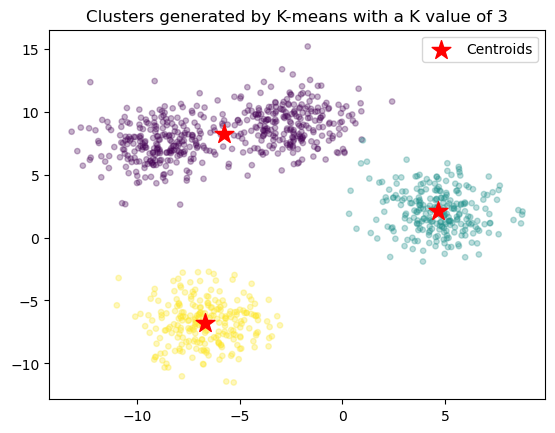

In [9]:
# K-means with a K value of 3 to demonstrate the effect of proximity in the clustering
kmeans = cluster.KMeans(n_clusters=3,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)

# Show the result
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 3")
plt.show()

Regarding achieving a better selection of the number of clusters, we have different possibilities. One of them is to evaluate how well-separated the points assigned to the clusters are for each value of K. This is the essence of the silhouette coefficient method. It is a measure of the separation between clusters, as opposed to the SSE measure, which indicates how compact the clusters are.

There are other mechanisms to evaluate the quality of our choice of K, such as validating the cluster assignments if we have labels indicating the class each point belongs to, as in our case. From a less technical perspective, we might mention that sometimes domain knowledge about the dataset can be enough to choose the value of K.

Now, let's look at an example and implementation of the silhouette coefficient method, taken from the scikit-learn website and applied to our data:

For n_clusters = 2 The average silhouette_score is : 0.5079334010289336
For n_clusters = 3 The average silhouette_score is : 0.6814833917748337
For n_clusters = 4 The average silhouette_score is : 0.6678992533189723
For n_clusters = 5 The average silhouette_score is : 0.5818872250046244
For n_clusters = 6 The average silhouette_score is : 0.48971564658585864


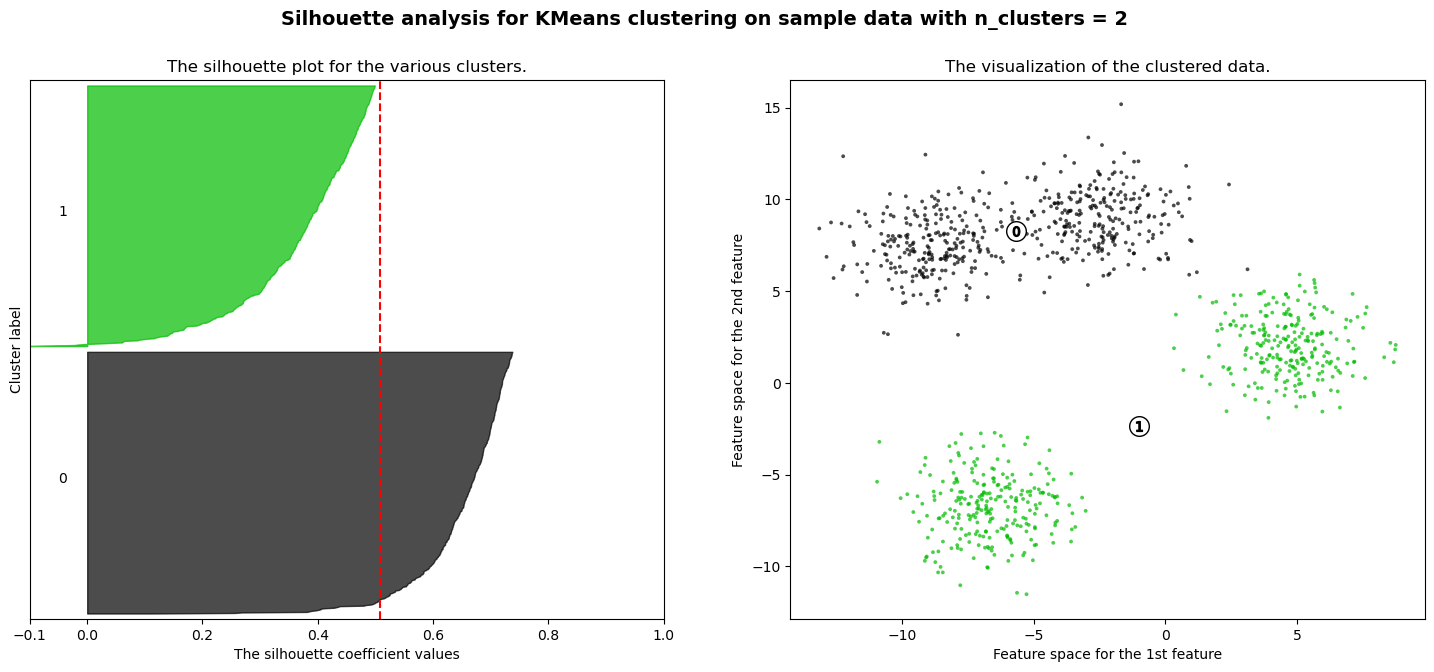

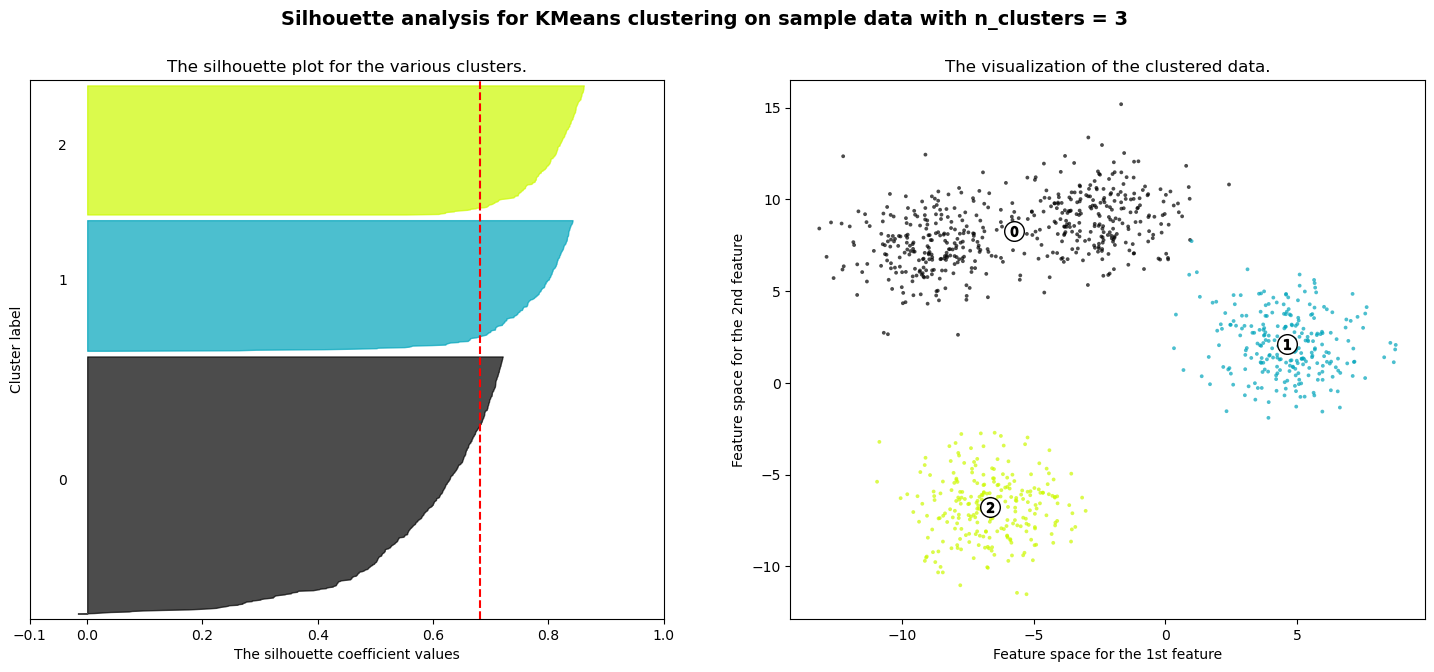

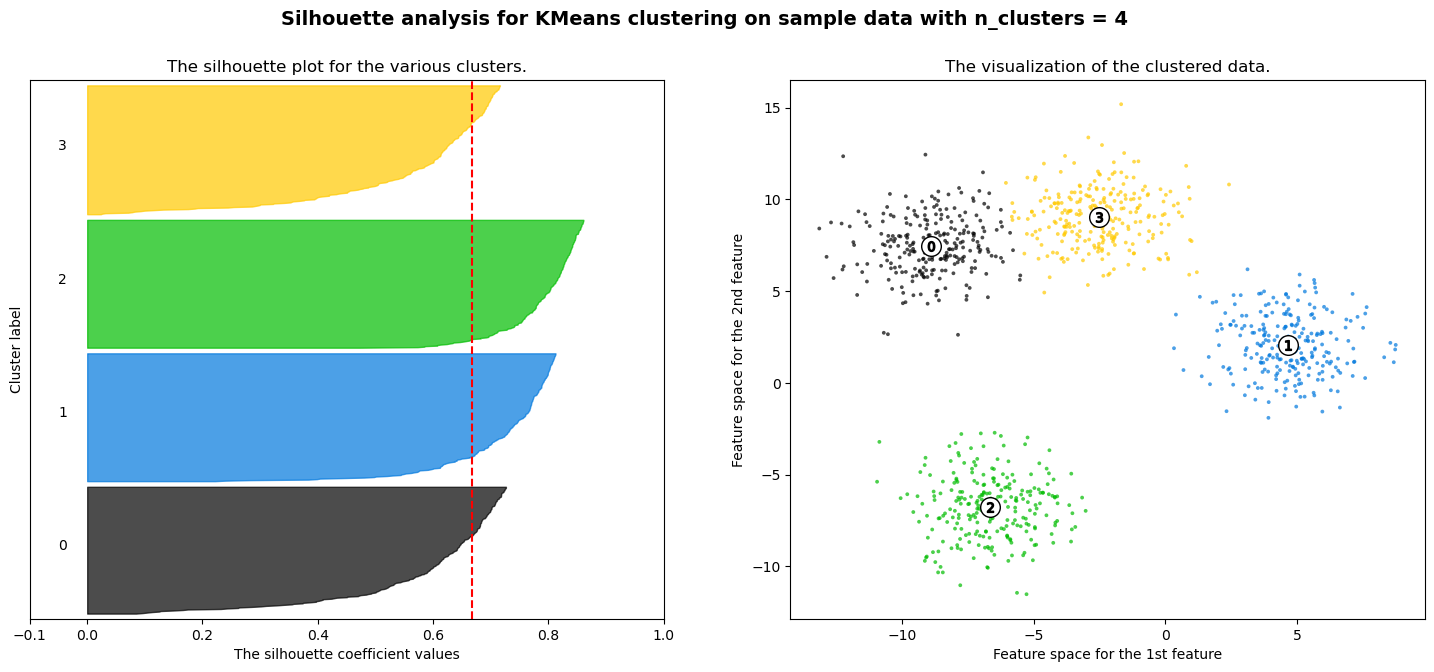

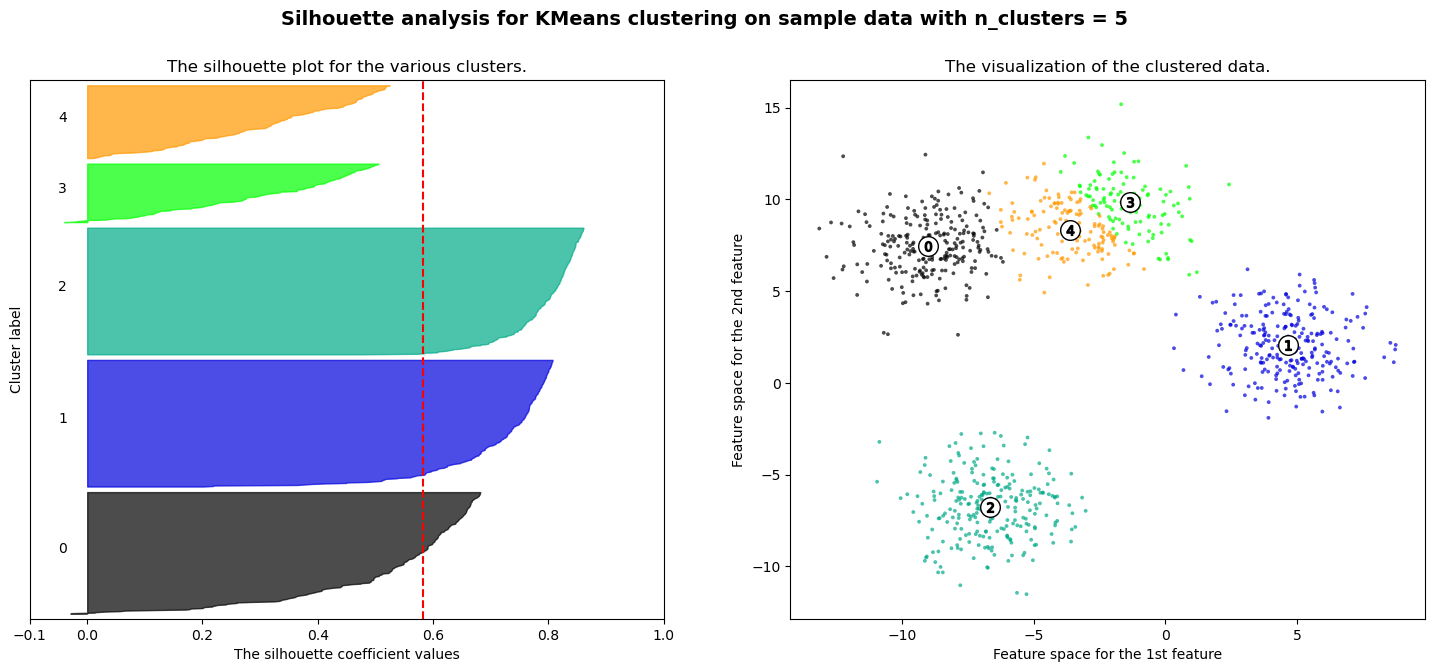

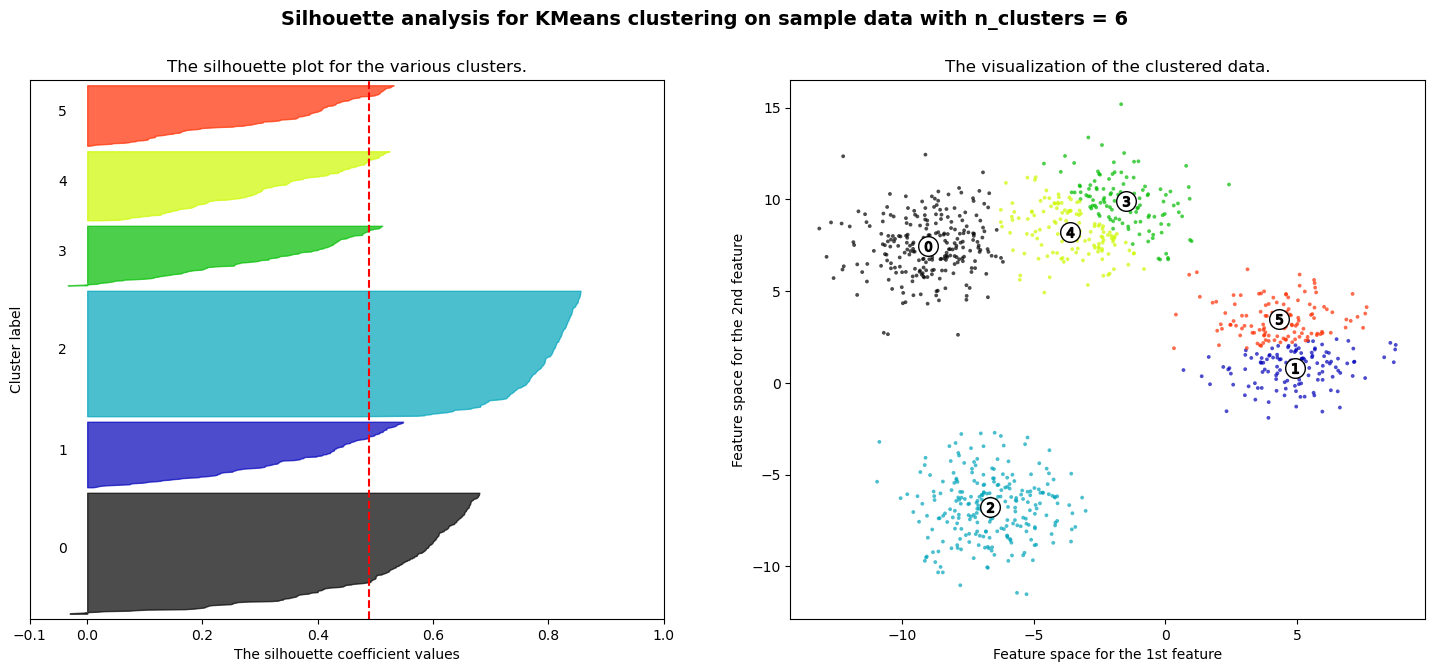

In [8]:
# Silhouette method implementation

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

In this case, the metric associated with the method is the silhouette coefficient. The closer the value is to 1, the better separated our clusters are. We see that the highest values are for K=3 (silhouette coefficient of 0.68) and K=4 (0.66). As we can see, the value is actually slightly better for 3 clusters than for 4.

I believe this is because, with k=3, the separation between the "macro-cluster" formed in the upper left corner of the graph and the other two smaller clusters is better than when K=4. In the latter case, the separation between the two clusters in the upper left corner becomes "poorer."

Here the implementation of the algorithm with K=4:

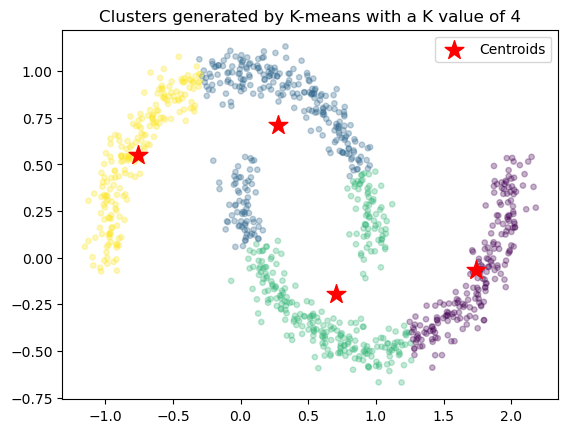

In [16]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=4,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 4")
plt.show()

As expected, we have 4 clusters similar to the "real" groups, and the centroids appear positioned as anticipated. Before continuing with the analysis, let's revisit those real groups because they will help us understand what we can expect from an algorithm like K-means:

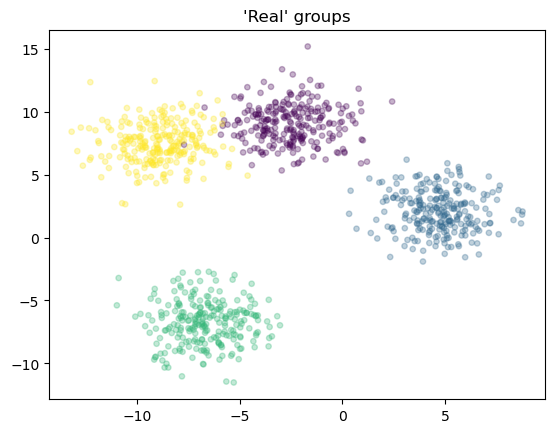

In [11]:
# Show the real groups for the Blobs dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real' groups")
plt.show()

We can begin the analysis by stating that the mechanism of K-means involves trying to minimize the distance (whichever distance metric we choose) between the points in the dataset and the centroids of the clusters. From this, a few considerations arise.

First, K-means works best with groups that have a relatively circular or spherical shape. This is easy to observe in a dataset like Blobs. Here, we have 4 groups where a center is easily noticeable, and the shape is relatively circular. Under these conditions, K-means performs well and can assign points to clusters in a way that closely matches reality.

In fact, we can calculate how well our algorithm has performed:

In [12]:
# 'Real' clusters have slightly different names compared to the K-means output clusteres, so I start by renaming them:

result_kmeans_rename = np.where(result_kmeans == 0, 3, np.where(result_kmeans == 3, 0, result_kmeans))

# Calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

99.2

We see that our K-means algorithm is correct 99.2% of the time. This case was particularly easy for this algorithm, but even so, we must note one more thing.

In cases where points that we know belong to one group are near or inside another group (there are some in this dataset), the assignment to a cluster will be incorrect. Additionally, wherever there are points on the "boundary" between two groups, it is more likely for the algorithm to make errors in the assignment.

## 1.1.2. K-Means with the Moons dataset

Here the elbow plot for the Moons dataset:

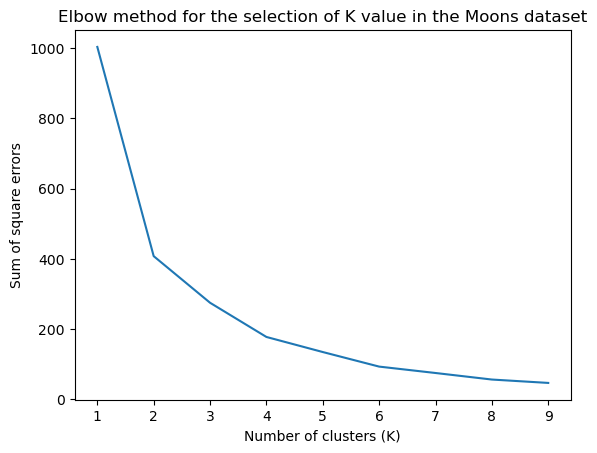

In [14]:
# Load the Moons dataset as X and y variables
X, y = X_moons, y_moons

# Empty list to save SSEs
inertias = []

# Iterate through K values 1 to 10 and calculate SSE for each K value
for el in range(1,10):
    kmeans = cluster.KMeans(n_clusters=el,n_init='auto', random_state = 42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
# Generate elbow plot
plt.plot(range(1,10), inertias)
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of square errors")
plt.title("Elbow method for the selection of K value in the Moons dataset")
plt.show()

We notice that in this dataset, the decrease in SSE is much less "abrupt" compared to the case of blobs. Therefore, choosing the number of clusters seems more difficult (we'll see below that this is indeed not the best dataset for K-means, given the "shape" of the groups). Two small elbows can be observed, one at K=2 and another at K=4. Below, we will visualize the result with both values.

In this case, I believe the best way to choose the value of K is by looking at the plot of the dataset points. Visually, it seems obvious that there are two groups, so that would be the ideal value to work with. I think using the silhouette coefficient criterion in this case would not make much sense because we know that K-means works by "placing" centroids and moving them based on the distances of points to those centroids, but it will not be able to generate well-separated groups with high silhouette coefficient values. We can see this with the code:

For n_clusters = 2 The average silhouette_score is : 0.48633947635957203
For n_clusters = 3 The average silhouette_score is : 0.4229980895895807
For n_clusters = 4 The average silhouette_score is : 0.4573975750690784
For n_clusters = 5 The average silhouette_score is : 0.4831806526436417
For n_clusters = 6 The average silhouette_score is : 0.5097793680426884


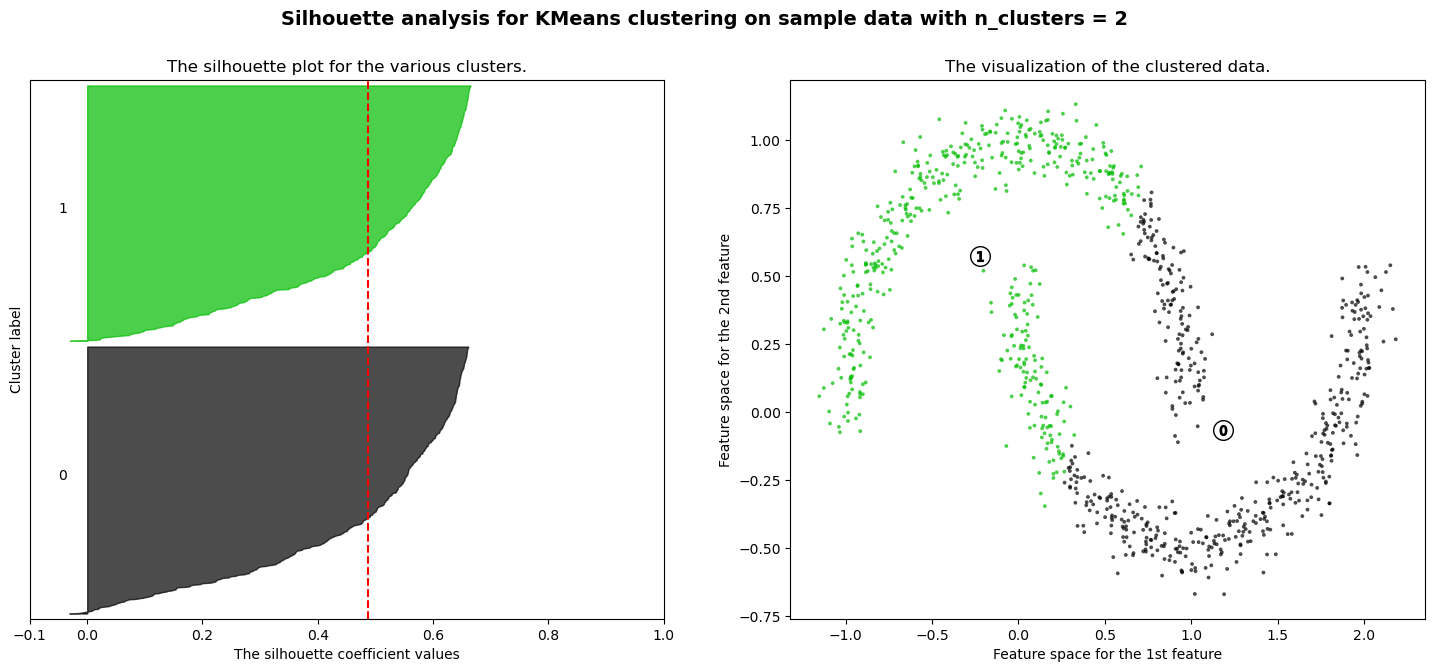

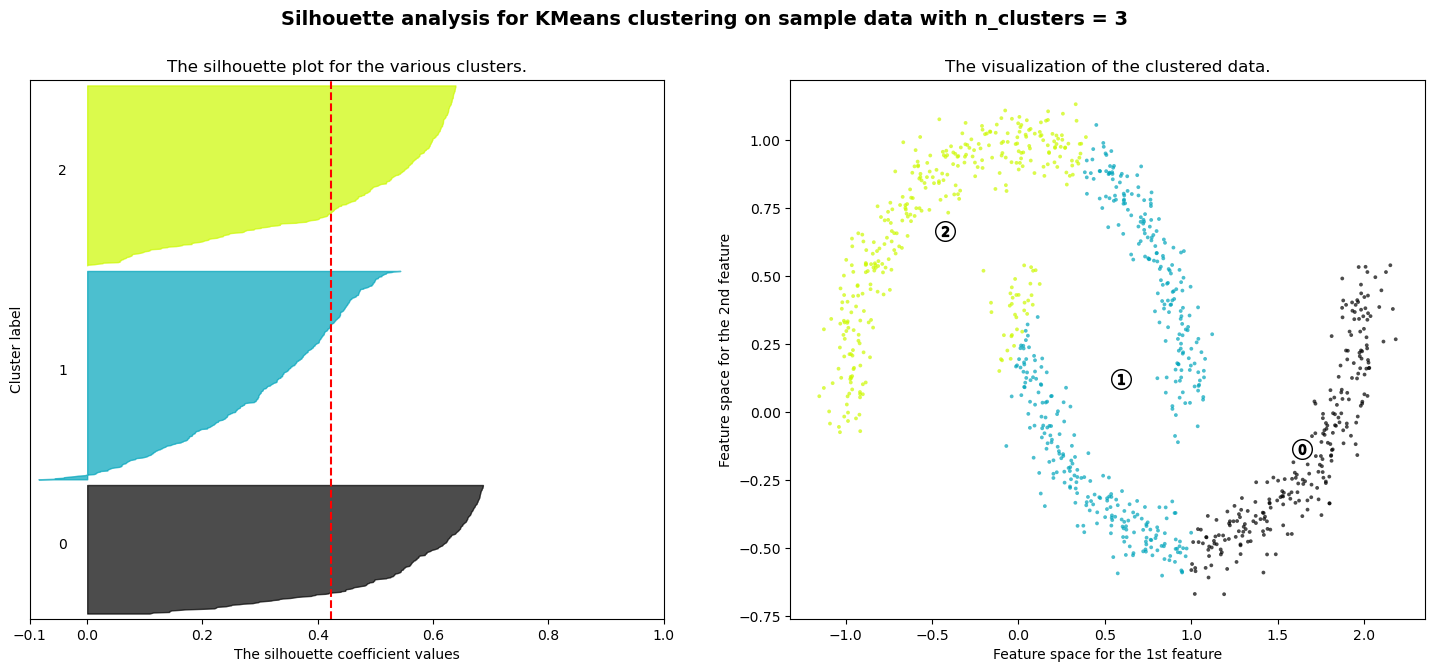

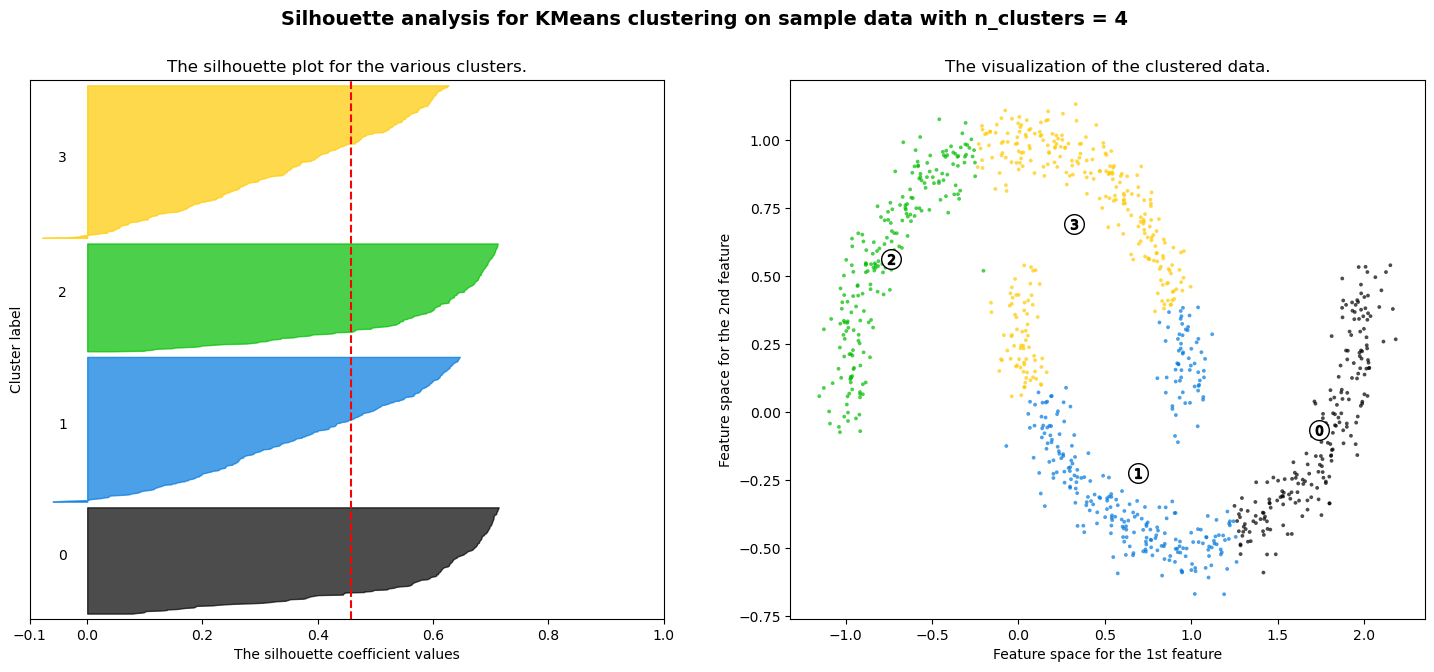

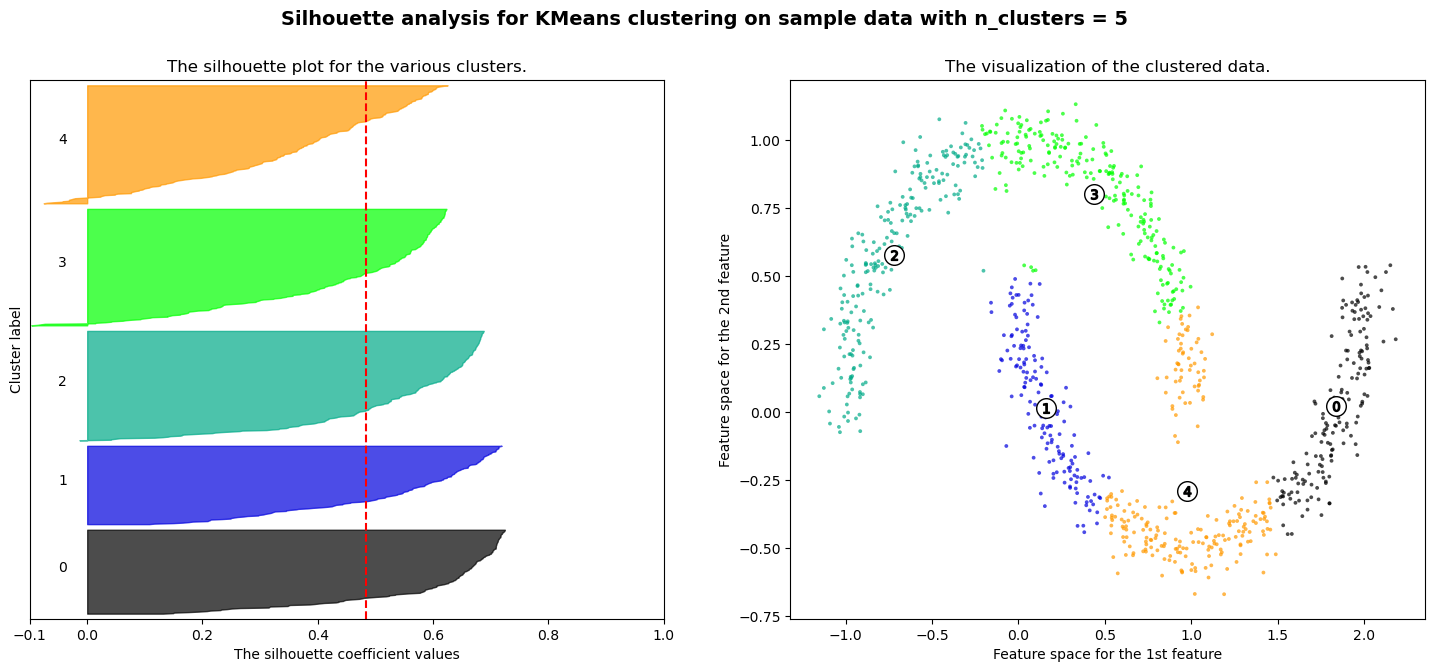

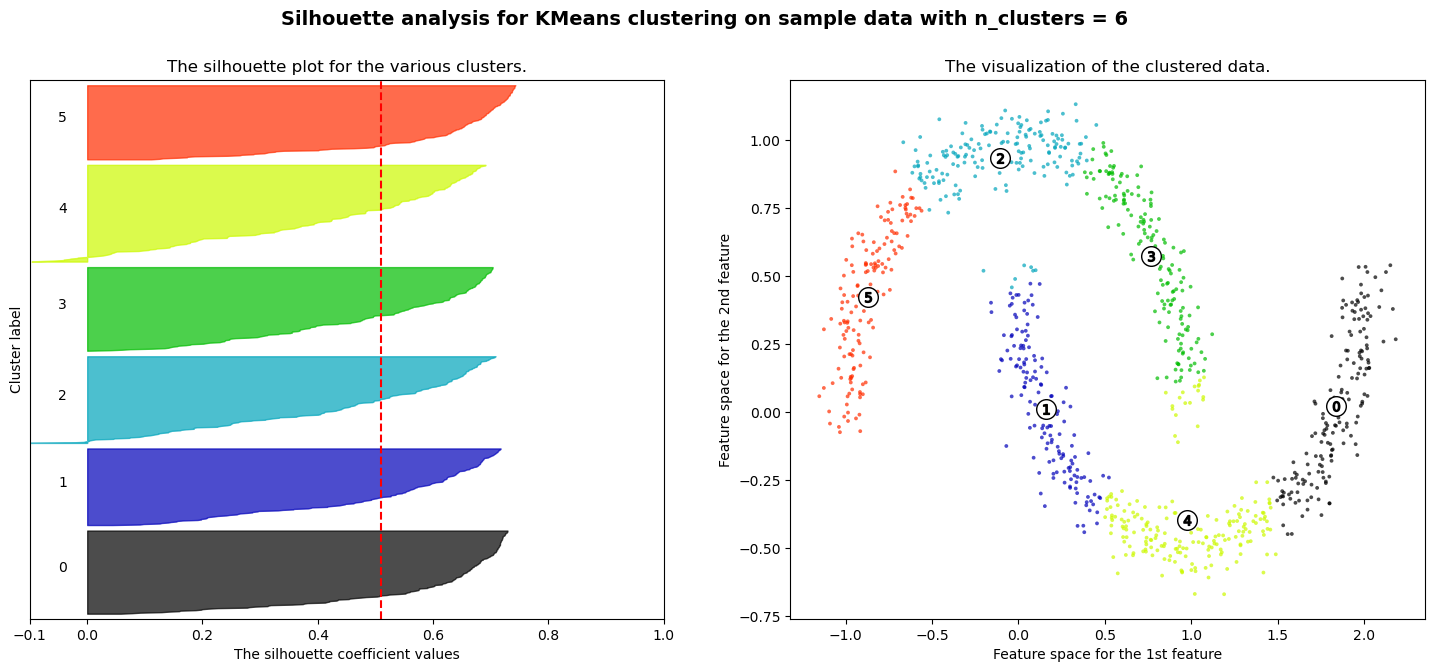

In [15]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = cluster.KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

We see that the average silhouette coefficient is lower in this case compared to the blobs dataset, which makes sense considering that, in the blobs case, K-means was assigning points to clusters that were similar to the real groups. However, in this case, K-means generates clusters that "cut" through the real groups, which results in a worse silhouette coefficient. This happens because K-means is trying to minimize the distance between points and centroids, but the actual group structure in this dataset does not align well with spherical or circular clusters, leading to less accurate assignments and a lower silhouette score.

This is the implementation with K=2:

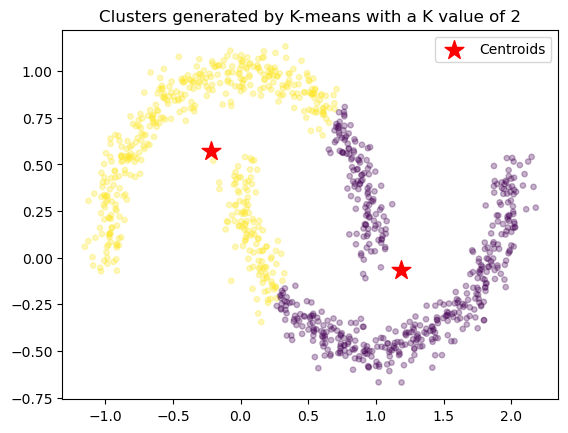

In [17]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=2,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 2")
plt.show()

Now, let's show the result for the other "relevant" value we extracted from the SSE plot, which is k=4:

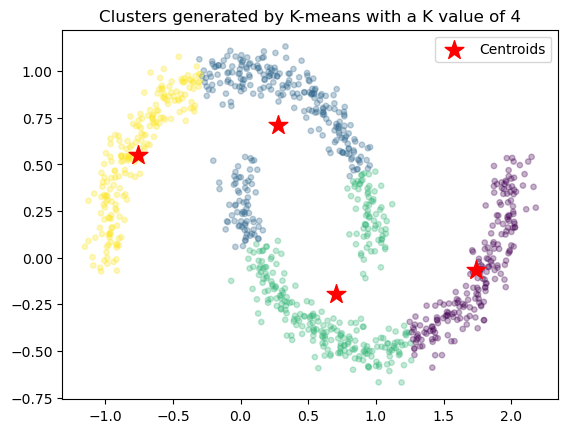

In [18]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=4,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Mostrar la asignación de puntos del dataset a los clústers
plt.scatter(X[:,0], X[:,1], s=15, c=result_kmeans, alpha=0.3)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
plt.legend()
plt.title("Clusters generated by K-means with a K value of 4")
plt.show()

As we mentioned, this dataset is not ideal for clustering using an algorithm like K-means. The reason is that the shape of the groups is not the most suitable because it is not circular or spherical. There isn't a center around which the points of each group cluster, so the K-means strategy fails to generate the clusters effectively.

If we look at the position of the centroids (let's take the plot with k=2 for simplicity), we see that the centroids are not in a region around which there is a point structure like the one we had in the blobs dataset. The two clusters are generated, as expected, based on the distances of the points to those centroids, but they don't resemble the real groups. In later exercises, we will see how using other algorithms that follow different strategies, we can generate appropriate clusters.

Before moving on, let's make another observation. As we can see, the centroids in the case of k=4 are much closer to the clouds of points. A bit later, we will leverage this to "artificially" generate clusters in which the assignment of points is almost identical to that of the real groups.

To assign a metric to the quality of our clustering using K-means, let's see what proportion of the points from the real groups we have been able to group correctly. First, let's look at what these "real" groups are:

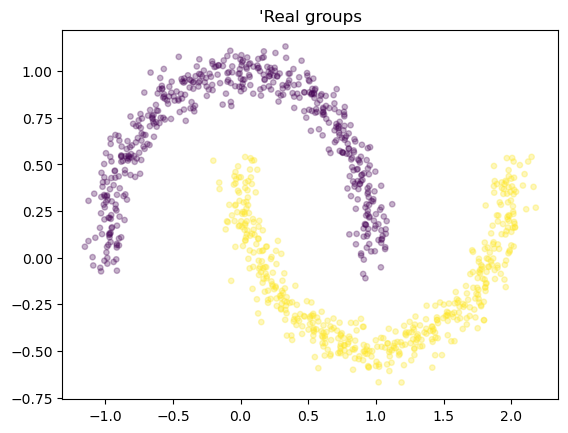

In [22]:
# Show the real groups in the moons dataset
plt.scatter(X[:,0], X[:,1], s=15, c=y, alpha=0.3)
plt.title("'Real groups")
plt.show()

Now, let's see what proportion of the points we have grouped correctly:

In [24]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=2,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)

# 'Real' clusters have slightly different names compared to the K-means output clusteres, so I start by renaming them:

result_kmeans_rename = np.where(result_kmeans == 0, 1, np.where(result_kmeans == 1, 0, result_kmeans))

# Calculate the percentage of coincidence between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

74.4

We see that the accuracy percentage drops to 74.4%. This is not equivalent to randomly assigning points to clusters, but it is far from the 99.2% accuracy we saw with the blobs dataset. The underlying idea here is that the shape of the groups (the distribution of the points) is what determines how effective an algorithm will be in clustering those points.

In fact, by manipulating the position of the points, we should be able to make K-means produce a result that is similar to a random assignment. This demonstrates that K-means is sensitive to the structure of the data and that its performance depends heavily on how well the data clusters match the algorithm's assumptions of spherical or circular clusters.

One could think about possibilities that might help K-means to perform better with this dataset. An obvious possibility would be to change the algorithm. But, if we want to delve deeper into the use of K-means, there are several ways we can make the clustering process more effective:

1. Add more dimensions: By simply adding extra dimensions that help separate the points, we might move closer to a more efficient clustering with K-means. The idea is to create more distance between the points of the two groups so that K-means can more easily distinguish between them.

2. Change the existing dimensions: This dataset might not be the best fit for this, but if we are able to perform dimensionality reduction (for example, in a dataset with more dimensions), we could obtain dimensions that better reflect the differences between the groups. This would make it easier for K-means to assign points to the correct clusters.

3. Combine K-means with other strategies: In this case, we can easily distinguish the two groups in the dataset. One way to "help" K-means do the same could be to ask it to generate a larger number of clusters (ensuring that it does not mix points from the two real groups in any one cluster), and then manually combine those clusters afterward. We can see an example of this, as well as the result it has on the clustering:

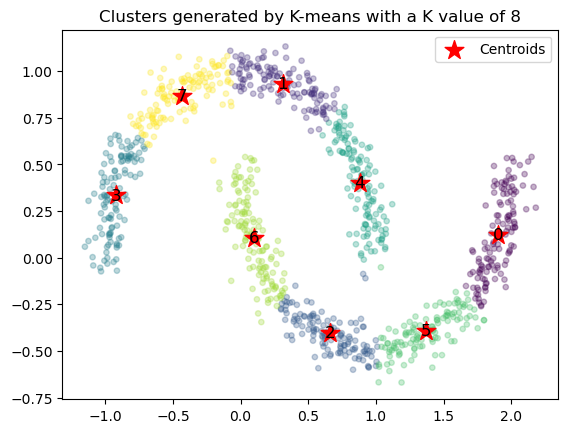

In [25]:
# Calculate clusters using K-means
kmeans = cluster.KMeans(n_clusters=8,n_init='auto', random_state = 42)
result_kmeans = kmeans.fit_predict(X)
    
# Show the clustering result
plt.scatter(X[:, 0], X[:, 1], s=15, c=result_kmeans, alpha=0.3)

# Set a label to each centroid to later bind them together
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], str(i), fontsize=12, color='black', ha='center', va='center')

plt.legend()
plt.title("Clusters generated by K-means with a K value of 8")
plt.show()

We can see that with 8 clusters, there are very few points that fall into the same cluster but belong to different real groups. If we now manually group these clusters (using the labels), we could approach the real groups more closely.

By increasing the number of clusters, we make it less likely that K-means will mix points from the different real groups. Afterward, by merging or reassociating these clusters manually, we can achieve a much closer match to the real groupings:

In [26]:
# Rename labels:
result_kmeans = np.where(result_kmeans == 3, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 7, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 1, 9, result_kmeans)
result_kmeans = np.where(result_kmeans == 4, 9, result_kmeans)

result_kmeans = np.where(result_kmeans != 9, 10, result_kmeans)

result_kmeans_rename = np.where(result_kmeans == 9, 0, np.where(result_kmeans == 10, 1, result_kmeans))

In [28]:
# And calculate the percentage of coincidences between the two:
coincidence = np.mean(y == result_kmeans_rename) * 100
coincidence

99.6

We see that we get much closer (99.6% accuracy) to the optimal result:

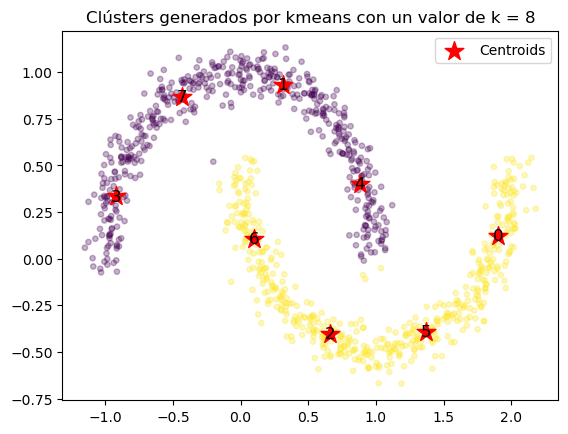

In [29]:
plt.scatter(X[:, 0], X[:, 1], s=15, c=result_kmeans_rename, alpha=0.3)

# Set a label to each centroid to later bind them together
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], str(i), fontsize=12, color='black', ha='center', va='center')

plt.legend()
plt.title("Clústers generados por kmeans con un valor de k = 8")
plt.show()

Obviously, this is a somewhat "artificial" way of achieving the result, but we are still using K-means to get there.